In this notebook, we will use tools like scikit, geopy, the Foursquare API and others, to analyze the neighborhoods of the city of Sao Paulo, in Brazil. More specifically, we will discuss the types of public and private venues available at different regions of the city and check how this data relates with key indicators like GDP per capita, HDI, criminality and others.

Let's start by importing the necessary modules:

- Requests and urllib, to allow inquiring data from websites
- Geopy, to get spatial coordinates from addresses
- BeautifulSoup, to decode HTML data properly (as addresses are in Portuguese and they include special characters)
- Numpy, Scipy, Pandas and Scikit-learn for the data preparation and modelling
- Folium, to enable map plotting

In [86]:
import requests
from geopy.geocoders import Nominatim
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import scipy as sc
import numpy as np
from sklearn.cluster import KMeans
import random
import time
import cv2
import folium
import pandas as pd
from folium.plugins import MarkerCluster
from matplotlib import pyplot as plt

CLIENT_ID = '2REBOOS3YFKNJDH4PVUAELAGFULDILSOVRNYA2OXOP3TH0GC' # your Foursquare ID
CLIENT_SECRET = 'HUYA1HXT0WXNO2UXSHYT4YD1E3RH2AID0IVAUBT41CTQDZR5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Next, we will access the coordinates of each neighborhood in the city - in Sao Paulo, they are called "subprefeituras". In the website below, we can find the address of the central administration of each neighborhood:

https://32xsp.org.br/2018/09/06/telefones-das-subprefeituras-de-sao-paulo/index.php

Let's then decode the HTML of this website to gather the address of each neighborhood's administration building, whose coordinates we will consider the center of the neighborhood:

In [7]:
# dictionary to allocate the address and coordinates of each 'subprefeitura'
subpref_addresses = {}

# gathering address of each neighborhood from the website below:
req = Request('https://32xsp.org.br/2018/09/06/telefones-das-subprefeituras-de-sao-paulo/index.php', headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
webpage = BeautifulSoup(webpage)

# removing unnecessary information and keeping only the address data
webpage = str(webpage).split("<p><strong>SUBPREFEITURAS</strong></p>")[1]
webpage = webpage.split("<p><em>Com informações da")[0]
subpref_gross_list = webpage.split("<p><strong>")[1:]

geolocator = Nominatim(user_agent="IBM_Data_Science")

# for each neighborhood, decoding the address data, reading the coordinates and filling the dictionary
for subpref_data in subpref_gross_list:
    name = subpref_data.split("<br/>")[0]
    address = subpref_data.split("Endereço:</strong>")[1]
    address = address.replace("</p>\n","")
    address = address.replace("\n","")
    address = address.split("–")[0] + ", São Paulo"
    try: location = geolocator.geocode(address)
    except: 
        time.sleep(5)
        location = geolocator.geocode(address)
    try: subpref_addresses[name] = [address, location.latitude, location.longitude]
    except: subpref_addresses[name] = [address, "NONE", "NONE"]

Let's investigate the data we gathered above. First, let's check if all neighborhoods were correctly identified. The city of Sao Paulo has a total of 32 'subprefeituras', as stated in the city official website (in Portuguese):

https://www.prefeitura.sp.gov.br/cidade/secretarias/subprefeituras/subprefeituras/index.php?p=8978

So, let's investigate the length of the dictionary we just filled above:

In [8]:
len(subpref_addresses)

32

Ok, so the number of the 'subprefeituras' is correct. Now let's check if the data was correctly imported for each of them:

In [9]:
for key in subpref_addresses:
    if "NONE" in subpref_addresses[key]:
        print(','.join([str(key),str(subpref_addresses[key])]))

BUTANTÃ,[' Rua Ulpiano da Costa Manso, 201 , São Paulo', 'NONE', 'NONE']
CIDADE ADEMAR,[' Avenida Yervant Kissajikain, 416 , São Paulo', 'NONE', 'NONE']
ITAIM PAULISTA,[' Avenida Marechal Tito 3012, CEP: 08115-000, São Paulo', 'NONE', 'NONE']
ITAQUERA,[' Rua Augusto Carlos Bauman, 851 CEP: 08210-590, São Paulo', 'NONE', 'NONE']
SÃO MATEUS,[' Rua Ragueb Chohfi, 1.400 , São Paulo', 'NONE', 'NONE']
SÃO MIGUEL,[' Rua Ana Flora Pinheiro de Sousa, 76 , São Paulo', 'NONE', 'NONE']


We can see that, for 6 of the 32 neighborhoods, the coordinates were not correctly identified, even though the address was retrieved correctly. Let's manually fill the coordinates of these 'subprefeituras':

In [10]:
subpref_addresses['BUTANTÃ'][1] = -23.5883813; subpref_addresses['BUTANTÃ'][2] = -46.7402937
subpref_addresses['CIDADE ADEMAR'][1] = -23.6672401; subpref_addresses['CIDADE ADEMAR'][2] = -46.6770408
subpref_addresses['ITAIM PAULISTA'][1] = -23.4943168; subpref_addresses['ITAIM PAULISTA'][2] = -46.419237
subpref_addresses['ITAQUERA'][1] = -23.5316553; subpref_addresses['ITAQUERA'][2] = -46.4494032
subpref_addresses['SÃO MATEUS'][1] = -23.5995437; subpref_addresses['SÃO MATEUS'][2] = -46.4712808
subpref_addresses['SÃO MIGUEL'][1] = -23.4998911; subpref_addresses['SÃO MIGUEL'][2] = -46.4521839

To check that now all the neighborhoods are identified and have the correct coordinates assigned, let's plot a map of Sao Paulo with pins for each of these 'subprefeituras':

In [183]:
# converting the data gathered before into a Pandas dataframe
df_subpref_saopaulo = pd.DataFrame.from_dict(subpref_addresses, orient='index', columns=["Address","Latitude","Longitude"])
df_subpref_saopaulo.index.name = "Neighborhood"

# coordinates of the geometrical center of Sao Paulo
city_latitude = -23.6821604
city_longitude = -46.5754942

# create map of Sao Paulo using latitude and longitude values
map_sao_paulo = folium.Map(location=[city_latitude,city_longitude], zoom_start=10, width='80%', height='100%')

# add neighborhood markers to map
for lat, lng, neighborhood in zip(df_subpref_saopaulo['Latitude'], 
                                           df_subpref_saopaulo['Longitude'], 
                                           df_subpref_saopaulo.index.values.tolist()):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sao_paulo)

# add city limits to the map
CityLimits = folium.FeatureGroup(name="City Limits")
CityLimits.add_child(folium.GeoJson(data="https://global.mapit.mysociety.org/area/1024313.geojson"))
map_sao_paulo.add_child(CityLimits)
map_sao_paulo.add_child(folium.map.LayerControl())
    
map_sao_paulo

We see that all of the neighborhood administration addresses fell within the city limits, as expected. One possible problem, though, is that two of the markers are too close from one another, as shown in the picture below. This may be due to an incorrect address or coordinate gathering, as it would not be natural that two 'subprefeituras' offices would be located next to one another:

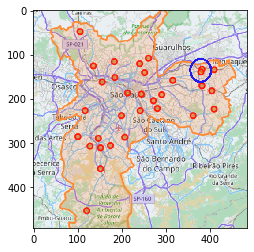

In [12]:
img = cv2.imread('close_neighborhoods.png')
plt.imshow(img)

If we hover through the Folium map, we can see that the two close neighborhoods are "São Miguel" and "Ermelino Matarazzo". A quick search in Google Maps show that, although the address is right, the coordinates for the "Ermelino Matarazzo" neighborhood are wrong. Let's update it manually and replot the map:

In [171]:
subpref_addresses['ERMELINO MATARAZZO'][1] = -23.5077086; subpref_addresses['ERMELINO MATARAZZO'][2] = -46.4817421

df_subpref_saopaulo = pd.DataFrame.from_dict(subpref_addresses, orient='index', columns=["Address","Latitude","Longitude"])
df_subpref_saopaulo.index.name = "Neighborhood"

# coordinates of the geometrical center of Sao Paulo
city_latitude = -23.6821604
city_longitude = -46.5754942

# create map of Sao Paulo using latitude and longitude values
map_sao_paulo = folium.Map(location=[city_latitude,city_longitude], zoom_start=10, width='80%', height='100%')

for lat, lng, neighborhood in zip(df_subpref_saopaulo['Latitude'], 
                                           df_subpref_saopaulo['Longitude'], 
                                           df_subpref_saopaulo.index.values.tolist()):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sao_paulo)

# add city limits to the map
CityLimits = folium.FeatureGroup(name="City Limits")
CityLimits.add_child(folium.GeoJson(data="https://global.mapit.mysociety.org/area/1024313.geojson"))
map_sao_paulo.add_child(CityLimits)
map_sao_paulo.add_child(folium.map.LayerControl())
    
map_sao_paulo

Now we have the correct distribution of the neighborhoods in the map.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000, limit = 200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)                                         
                                           
saopaulo_venues = getNearbyVenues(names=df_subpref_saopaulo.index.values.tolist(),
                                   latitudes=df_subpref_saopaulo['Latitude'],
                                   longitudes=df_subpref_saopaulo['Longitude'])

In [15]:
saopaulo_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ARICANDUVA / VILA FORMOSA,-23.551774,-46.548753,"Centro Esportivo, Recreativo e Educativo do Tr...",-23.555365,-46.549868,Park
1,ARICANDUVA / VILA FORMOSA,-23.551774,-46.548753,Padaria Crillon,-23.549081,-46.549856,Bakery
2,ARICANDUVA / VILA FORMOSA,-23.551774,-46.548753,Arena Fitness Academia,-23.557181,-46.549724,Gym
3,ARICANDUVA / VILA FORMOSA,-23.551774,-46.548753,Urizun Produtos Orientais,-23.552705,-46.553506,Grocery Store
4,ARICANDUVA / VILA FORMOSA,-23.551774,-46.548753,Barão Do Valle,-23.555363,-46.549845,Seafood Restaurant
...,...,...,...,...,...,...,...
3073,VILA PRUDENTE,-23.582753,-46.559775,Bona's Carnes,-23.552434,-46.583091,Steakhouse
3074,VILA PRUDENTE,-23.582753,-46.559775,Lo Spaghetto Cantina,-23.546484,-46.565243,Italian Restaurant
3075,VILA PRUDENTE,-23.582753,-46.559775,Hocca Bar,-23.580101,-46.594604,Sandwich Place
3076,VILA PRUDENTE,-23.582753,-46.559775,Padaria Crillon,-23.549081,-46.549856,Bakery


In [225]:
# one hot encoding
saopaulo_onehot = pd.get_dummies(saopaulo_venues[['Venue Category']], prefix="", prefix_sep="")


# add neighborhood column back to dataframe
saopaulo_onehot['Neighborhood'] = saopaulo_venues['Neighborhood'] 
#saopaulo_onehot = saopaulo_onehot[ ['Neighborhood'] + [ col for col in saopaulo_onehot.columns if col != 'Neighborhood' ] ]

saopaulo_grouped = saopaulo_onehot.groupby('Neighborhood')
saopaulo_grouped_means = saopaulo_grouped.mean()
saopaulo_grouped_means['Bakery']

Neighborhood
ARICANDUVA / VILA FORMOSA      0.070000
BUTANTÃ                        0.040000
CAMPO LIMPO                    0.090000
CAPELA DO SOCORRO              0.109890
CASA VERDE                     0.010000
CIDADE ADEMAR                  0.080000
CIDADE TIRADENTES              0.110000
ERMELINO MATARAZZO             0.070000
FREGUESIA DO Ó                 0.070000
GUAIANASES                     0.120000
IPIRANGA                       0.030000
ITAIM PAULISTA                 0.080000
ITAQUERA                       0.100000
JABAQUARA                      0.070000
JAÇANÃ / TREMEMBÉ              0.110000
LAPA                           0.020000
MOOCA                          0.030000
M’BOI MIRIM                    0.050000
PARELHEIROS                    0.000000
PENHA                          0.040000
PERUS                          0.122222
PINHEIROS                      0.060000
PIRITUBA                       0.130000
SANTANA / TUCURUVI             0.100000
SANTO AMARO                

In [17]:
saopaulo_grouped_top = saopaulo_onehot.groupby('Neighborhood').mean().reset_index()

for hood in saopaulo_grouped_top['Neighborhood']:
    print(hood)
    temp = saopaulo_grouped_top[saopaulo_grouped_top['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(20))
    print('\n')

ARICANDUVA / VILA FORMOSA
                      venue  freq
0                    Bakery  0.07
1               Pizza Place  0.05
2              Dessert Shop  0.05
3        Italian Restaurant  0.05
4                 Pet Store  0.03
5              Burger Joint  0.03
6               Supermarket  0.03
7                    Market  0.03
8        Seafood Restaurant  0.03
9                       Gym  0.03
10           Ice Cream Shop  0.03
11               Steakhouse  0.03
12           Chocolate Shop  0.02
13           Cosmetics Shop  0.02
14  Fruit & Vegetable Store  0.02
15             Soccer Field  0.02
16            Grocery Store  0.02
17              Candy Store  0.02
18     Gym / Fitness Center  0.02
19                      Bar  0.02


BUTANTÃ
                        venue  freq
0                      Bakery  0.04
1                        Park  0.04
2                    Pharmacy  0.04
3                   BBQ Joint  0.04
4               Grocery Store  0.03
5                 Supermarket  0.0

                   venue  freq
0                 Bakery  0.15
1   Brazilian Restaurant  0.10
2                    Gym  0.07
3            Pizza Place  0.07
4           Dessert Shop  0.05
5              BBQ Joint  0.04
6   Gym / Fitness Center  0.02
7                   Park  0.02
8         Farmers Market  0.02
9              Pet Store  0.02
10           Snack Place  0.02
11     Convenience Store  0.02
12            Restaurant  0.02
13            Food Truck  0.02
14        Chocolate Shop  0.02
15               Brewery  0.01
16        Ice Cream Shop  0.01
17            Pastelaria  0.01
18          Burger Joint  0.01
19                 Plaza  0.01


SÃO MIGUEL
                      venue  freq
0               Pizza Place  0.08
1                    Bakery  0.06
2       Japanese Restaurant  0.06
3      Gym / Fitness Center  0.05
4                       Gym  0.05
5                Restaurant  0.05
6                       Bar  0.04
7            Sandwich Place  0.03
8                 Pet Store  0

In [18]:
list(saopaulo_onehot.columns)

['Acai House',
 'Accessories Store',
 'Aquarium',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Arts & Entertainment',
 'Asian Restaurant',
 'Athletics & Sports',
 'BBQ Joint',
 'Baby Store',
 'Bagel Shop',
 'Baiano Restaurant',
 'Bakery',
 'Bar',
 'Beer Bar',
 'Beer Garden',
 'Beer Store',
 'Big Box Store',
 'Bike Shop',
 'Bistro',
 'Bookstore',
 'Botanical Garden',
 'Boutique',
 'Brasserie',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Buffet',
 'Burger Joint',
 'Butcher',
 'Café',
 'Candy Store',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Church',
 'Churrascaria',
 'Climbing Gym',
 'Clothing Store',
 'Coffee Shop',
 'College & University',
 'College Gym',
 'Comfort Food Restaurant',
 'Concert Hall',
 'Construction & Landscaping',
 'Convenience Store',
 'Cosmetics Shop',
 'Coworking Space',
 'Creperie',
 'Cultural Center',
 'Cupcake Shop',
 'Cycle Studio',
 'Dance Studio',
 'Deli / Bodega',
 'Dep

In [36]:
saopaulo_grouped.mean()['Jazz Club']

Neighborhood
ARICANDUVA / VILA FORMOSA      0.00
BUTANTÃ                        0.00
CAMPO LIMPO                    0.00
CAPELA DO SOCORRO              0.00
CASA VERDE                     0.00
CIDADE ADEMAR                  0.00
CIDADE TIRADENTES              0.00
ERMELINO MATARAZZO             0.00
FREGUESIA DO Ó                 0.00
GUAIANASES                     0.00
IPIRANGA                       0.00
ITAIM PAULISTA                 0.00
ITAQUERA                       0.00
JABAQUARA                      0.00
JAÇANÃ / TREMEMBÉ              0.00
LAPA                           0.00
MOOCA                          0.00
M’BOI MIRIM                    0.00
PARELHEIROS                    0.00
PENHA                          0.00
PERUS                          0.00
PINHEIROS                      0.00
PIRITUBA                       0.00
SANTANA / TUCURUVI             0.00
SANTO AMARO                    0.00
SAPOPEMBA                      0.00
SÃO MATEUS                     0.00
SÃO MIGUEL     

In [20]:
key_indicators_sp = pd.read_excel("DEINFO_IDH_UDH_2000_2010.xls", sheet_name="DEINFO_IDH_UDH_2000_2010")

In [28]:
key_indicators_organized = key_indicators_sp.groupby('PREFREG').mean()[['R1040','RDPC','IDHM','T_DES18M','I_ESCOLARIDADE', 'T_MULCHEFEFIF014', 'T_SLUZ', 'RDPC1','RDPC10','SOBRE60']]
key_indicators_organized.columns = ['Ratio_10/40', 'GDP_per_capita', 'HDI', 'Unemployment_18', 'Scholarity_index','Single_mother_no_scholarity_ratio','Ratio_no_electricity','GDP_20pct_poorest','GDP_10pct_richest','Probability_live_over_60']
key_indicators_organized

,Ratio_10/40,GDP_per_capita,HDI,Unemployment_18,Scholarity_index,Single_mother_no_scholarity_ratio,Ratio_no_electricity,GDP_20pct_poorest,GDP_10pct_richest,Probability_live_over_60
PREFREG,,,,,,,,,,
Aricanduva/Formosa/Carrão,9.981618,1128.690588,0.755000,11.746471,0.595294,34.961324,0.041029,245.620147,3994.578824,83.833676
Butantã,10.401278,1491.803056,0.749411,11.476500,0.597039,40.495222,0.120611,275.225611,5650.867500,82.925333
Campo Limpo,9.997455,898.597515,0.696491,13.302182,0.512618,48.559697,0.118000,186.461333,3310.635879,80.442000
Capela do Socorro,9.372147,905.386196,0.685963,14.723988,0.503276,51.650859,0.087362,186.454847,3562.631840,79.083620
Casa Verde/Cachoeirinha,9.558113,945.178208,0.733604,12.913019,0.576066,44.009528,0.086415,216.534340,3143.106038,82.040943
Cidade Ademar,11.299930,1077.136294,0.707392,13.650979,0.529336,47.912028,0.065455,206.334406,4840.371329,80.524406
Cidade Tiradentes,8.004848,476.480000,0.659000,17.036061,0.485545,50.268788,0.192424,126.540000,1476.710303,76.882727
Ermelino Matarazzo,9.565556,813.911975,0.717210,13.849630,0.545988,45.164568,0.089136,190.427284,2841.501605,81.587654
Freguesia/Brasilândia,8.960886,931.219494,0.736316,12.085063,0.591595,42.102785,0.108608,224.090633,3038.399620,83.040000


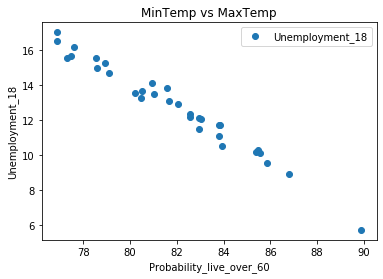

In [47]:
key_indicators_organized.plot(x='Probability_live_over_60', y='Unemployment_18', style='o')  
plt.title('MinTemp vs MaxTemp')  
plt.xlabel('Probability_live_over_60')  
plt.ylabel('Unemployment_18')  
plt.show()

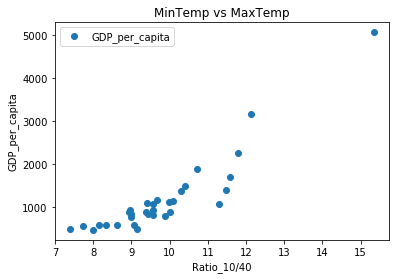

In [49]:
key_indicators_organized.plot(x='Ratio_10/40', y='GDP_per_capita', style='o')  
plt.title('MinTemp vs MaxTemp')  
plt.xlabel('Ratio_10/40')  
plt.ylabel('GDP_per_capita')  
plt.show()

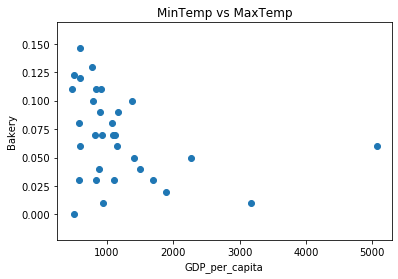

In [56]:
plt.scatter(key_indicators_organized['GDP_per_capita'], saopaulo_grouped_means['Bakery'])  
plt.title('MinTemp vs MaxTemp')  
plt.xlabel('GDP_per_capita')  
plt.ylabel('Bakery')  
plt.show()

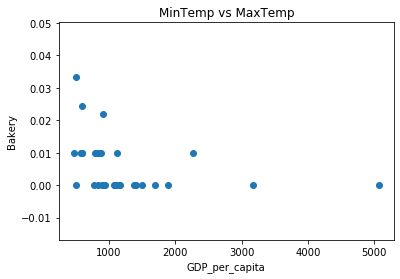

In [57]:
plt.scatter(key_indicators_organized['GDP_per_capita'], saopaulo_grouped_means['Convenience Store'])  
plt.title('MinTemp vs MaxTemp')  
plt.xlabel('GDP_per_capita')  
plt.ylabel('Bakery')  
plt.show()

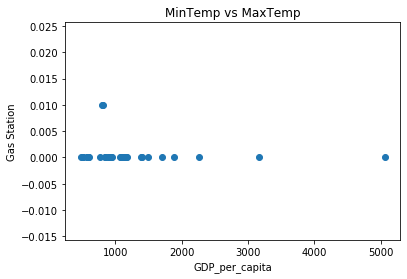

In [61]:
plt.scatter(key_indicators_organized['GDP_per_capita'], saopaulo_grouped_means['Gas Station'])  
plt.title('MinTemp vs MaxTemp')  
plt.xlabel('GDP_per_capita')  
plt.ylabel('Gas Station')  
plt.show()

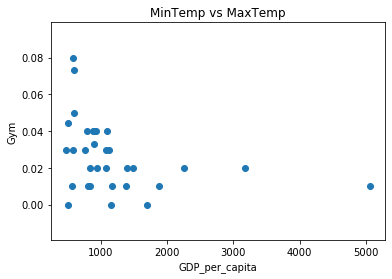

In [63]:
plt.scatter(key_indicators_organized['GDP_per_capita'], saopaulo_grouped_means['Gym'])  
plt.title('MinTemp vs MaxTemp')  
plt.xlabel('GDP_per_capita')  
plt.ylabel('Gym')  
plt.show()

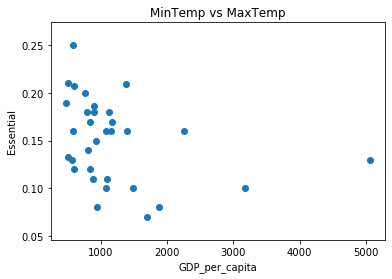

In [94]:
essential = saopaulo_grouped_means['Gas Station']+saopaulo_grouped_means['Convenience Store']+saopaulo_grouped_means['Bakery']
essential = essential + saopaulo_grouped_means['Market']+saopaulo_grouped_means['Supermarket']+saopaulo_grouped_means['Bar']
essential = essential +saopaulo_grouped_means['Train Station']+ saopaulo_grouped_means['Shopping Mall'] + saopaulo_grouped_means['Salon / Barbershop']
plt.scatter(key_indicators_organized['GDP_per_capita'],essential )  
plt.title('MinTemp vs MaxTemp')  
plt.xlabel('GDP_per_capita')  
plt.ylabel('Essential')  
plt.show()

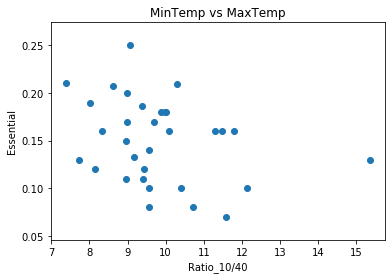

In [95]:
essential_2 = saopaulo_grouped_means['Gas Station']+saopaulo_grouped_means['Convenience Store']+saopaulo_grouped_means['Bakery']
essential_2 = essential_2 + saopaulo_grouped_means['Market']+saopaulo_grouped_means['Supermarket']+saopaulo_grouped_means['Bar']
essential_2 = essential_2 +saopaulo_grouped_means['Train Station']+ saopaulo_grouped_means['Shopping Mall'] + saopaulo_grouped_means['Salon / Barbershop']
plt.scatter(key_indicators_organized['Ratio_10/40'],essential_2 )  
plt.title('MinTemp vs MaxTemp')  
plt.xlabel('Ratio_10/40')  
plt.ylabel('Essential')  
plt.show()

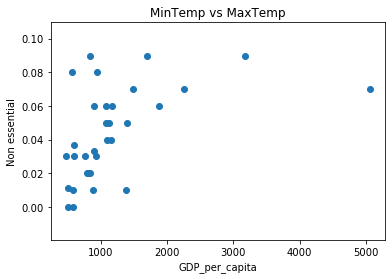

In [239]:
non_essential = saopaulo_grouped_means['Yoga Studio']+saopaulo_grouped_means['Wine Bar']+saopaulo_grouped_means['Spa']
non_essential = non_essential + saopaulo_grouped_means['Science Museum']+saopaulo_grouped_means['History Museum']+saopaulo_grouped_means['Jazz Club']
non_essential = non_essential + saopaulo_grouped_means['Climbing Gym']+saopaulo_grouped_means['Art Gallery']+saopaulo_grouped_means['Art Museum']
non_essential = non_essential + saopaulo_grouped_means['Theater']+saopaulo_grouped_means['French Restaurant']+saopaulo_grouped_means['Pet Store']
plt.scatter(key_indicators_organized['GDP_per_capita'],non_essential )  
plt.title('MinTemp vs MaxTemp')  
plt.xlabel('GDP_per_capita')  
plt.ylabel('Non essential')  
plt.show()

In [258]:
kclusters = 4

essential_df = pd.Series.to_frame(essential)
non_essential_df = pd.Series.to_frame(non_essential)
key_venues_df = pd.concat([essential_df,non_essential_df],axis=1)
key_venues_df /= key_venues_df.max()

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=random.randint(0,1000)).fit(key_venues_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

indexes = df_subpref_saopaulo.index.values
new_index = saopaulo_grouped_means.index.values.tolist()
for item,_ in enumerate(indexes):
    indexes[item] = new_index[item]

key_venues_df.insert(0, 'Cluster Labels', kmeans.labels_)
key_venues_df = pd.concat([key_venues_df,df_subpref_saopaulo['Latitude'],df_subpref_saopaulo['Longitude']],axis=1)
#saopaulo_grouped_means
key_venues_df

,Cluster Labels,0,0,Latitude,Longitude
Neighborhood,,,,,
ARICANDUVA / VILA FORMOSA,3,0.720000,0.555556,-23.551774,-46.548753
BUTANTÃ,0,0.400000,0.777778,-23.588381,-46.740294
CAMPO LIMPO,3,0.720000,0.666667,-23.647416,-46.757482
CAPELA DO SOCORRO,2,0.747253,0.366300,-23.720515,-46.701783
CASA VERDE,0,0.320000,0.888889,-23.512730,-46.666450
CIDADE ADEMAR,3,0.640000,0.666667,-23.667240,-46.677041
CIDADE TIRADENTES,2,0.760000,0.333333,-23.583889,-46.418290
ERMELINO MATARAZZO,1,0.560000,0.222222,-23.507709,-46.481742
FREGUESIA DO Ó,1,0.600000,0.333333,-23.476314,-46.666661


In [259]:
sp_merged = key_venues_df.merge(saopaulo_grouped_means,
                                       left_on='Neighborhood', 
                                       right_on='Neighborhood',)


sp_merged

,Cluster Labels_x,0,0,Latitude_x,Longitude_x,Cluster Labels_y,Acai House,Accessories Store,Aquarium,Arepa Restaurant,...,Video Game Store,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Latitude_y,Longitude_y
Neighborhood,,,,,,,,,,,,,,,,,,,,,
ARICANDUVA / VILA FORMOSA,3,0.720000,0.555556,-23.551774,-46.548753,4,0.00,0.00,0.00,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-23.551774,-46.548753
BUTANTÃ,0,0.400000,0.777778,-23.588381,-46.740294,3,0.00,0.00,0.00,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-23.588381,-46.740294
CAMPO LIMPO,3,0.720000,0.666667,-23.647416,-46.757482,4,0.00,0.00,0.00,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-23.647416,-46.757482
CAPELA DO SOCORRO,2,0.747253,0.366300,-23.720515,-46.701783,4,0.00,0.00,0.00,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-23.720515,-46.701783
CASA VERDE,0,0.320000,0.888889,-23.512730,-46.666450,1,0.00,0.00,0.00,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-23.512730,-46.666450
CIDADE ADEMAR,3,0.640000,0.666667,-23.667240,-46.677041,2,0.01,0.00,0.00,0.000000,...,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,-23.667240,-46.677041
CIDADE TIRADENTES,2,0.760000,0.333333,-23.583889,-46.418290,4,0.00,0.00,0.01,0.000000,...,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,-23.583889,-46.418290
ERMELINO MATARAZZO,1,0.560000,0.222222,-23.507709,-46.481742,2,0.00,0.00,0.00,0.000000,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-23.507709,-46.481742
FREGUESIA DO Ó,1,0.600000,0.333333,-23.476314,-46.666661,2,0.00,0.00,0.00,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-23.476314,-46.666661


In [260]:
# create map

city_latitude = -23.6821604
city_longitude = -46.5754942

map_clusters = folium.Map(location=[city_latitude,city_longitude], zoom_start=10, width='80%', height='100%')

import matplotlib.cm as cm
import matplotlib.colors as colors


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(key_venues_df['Latitude'], 
                                  key_venues_df['Longitude'], 
                                  list(key_venues_df.index.values), 
                                  key_venues_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# add city limits to the map
CityLimits = folium.FeatureGroup(name="City Limits")
CityLimits.add_child(folium.GeoJson(data="https://global.mapit.mysociety.org/area/1024313.geojson"))
map_clusters.add_child(CityLimits)
map_clusters.add_child(folium.map.LayerControl())
    
map_clusters

In [256]:
kclusters = 3

gdp_df = pd.Series.to_frame(key_indicators_organized['GDP_per_capita'])
hdi_df = pd.Series.to_frame(key_indicators_organized['HDI'])
r1040_df = pd.Series.to_frame(key_indicators_organized['Ratio_10/40'])
selected_key_indicators = pd.concat([gdp_df,hdi_df,r1040_df],axis=1)
selected_key_indicators.index.name = 'Neighborhood'

indexes = df_subpref_saopaulo.index.values
new_index = selected_key_indicators.index.values.tolist()
for item,_ in enumerate(indexes):
    indexes[item] = new_index[item]
    
selected_key_indicators

# run k-means clustering
kmeans_gdp = KMeans(n_clusters=kclusters, random_state=random.randint(0,1000)).fit(selected_key_indicators)

sp_gdp_merged = selected_key_indicators.merge(df_subpref_saopaulo,
                                       left_on='Neighborhood', 
                                       right_on='Neighborhood',)

sp_gdp_merged.insert(0, 'Cluster Labels', kmeans_gdp.labels_)

sp_gdp_merged

,Cluster Labels,GDP_per_capita,HDI,Ratio_10/40,Address,Latitude,Longitude
Neighborhood,,,,,,,
Aricanduva/Formosa/Carrão,0,1128.690588,0.755000,9.981618,"Rua Atucuri, 699 , São Paulo",-23.551774,-46.548753
Butantã,0,1491.803056,0.749411,10.401278,"Rua Ulpiano da Costa Manso, 201 , São Paulo",-23.588381,-46.740294
Campo Limpo,3,898.597515,0.696491,9.997455,"Rua Nossa Senhora do Bom Conselho, 59 , São P...",-23.647416,-46.757482
Capela do Socorro,3,905.386196,0.685963,9.372147,"Rua Cassiano dos Santos, 499 , São Paulo",-23.720515,-46.701783
Casa Verde/Cachoeirinha,3,945.178208,0.733604,9.558113,"Avenida Ordem e Progresso, 1001 , São Paulo",-23.512730,-46.666450
Cidade Ademar,0,1077.136294,0.707392,11.299930,"Avenida Yervant Kissajikain, 416 , São Paulo",-23.667240,-46.677041
Cidade Tiradentes,3,476.480000,0.659000,8.004848,"Rua Juá Mirim, s/n , São Paulo",-23.583889,-46.418290
Ermelino Matarazzo,3,813.911975,0.717210,9.565556,"Avenida São Miguel, 5550 , São Paulo",-23.507709,-46.481742
Freguesia/Brasilândia,3,931.219494,0.736316,8.960886,"Avenida João Marcelino Branco, 95 , São Paulo",-23.476314,-46.666661


In [257]:
# create map

city_latitude = -23.6821604
city_longitude = -46.5754942

map_clusters = folium.Map(location=[city_latitude,city_longitude], zoom_start=10, width='80%', height='100%')

import matplotlib.cm as cm
import matplotlib.colors as colors


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sp_gdp_merged['Latitude'], 
                                  sp_gdp_merged['Longitude'], 
                                  list(sp_gdp_merged.index.values), 
                                  sp_gdp_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# add city limits to the map
CityLimits = folium.FeatureGroup(name="City Limits")
CityLimits.add_child(folium.GeoJson(data="https://global.mapit.mysociety.org/area/1024313.geojson"))
map_clusters.add_child(CityLimits)
map_clusters.add_child(folium.map.LayerControl())
    
map_clusters